In [152]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings; warnings.filterwarnings('ignore')
import matplotlib.path as mpath

import sys; sys.path.append("..")
from dataset_manipulation import *
from palette import *
from plot import *

In [212]:
casealias = ['CTRL','IDEAL-ON', 'IDEAL-OFF', 'REAL-ON', 'REAL-OFF']
fig_folder = '../../figures/results/'
boreal_lat=50.

In [177]:
def load_dataset_dict(variable, cases=casealias, boreal_lat=45.):
    processed_path = '../../processed-data/postprocessing/' #/Users/adelezaini/Desktop/master-thesis/processed-data/output/IDEAL-ON_BVOC_20082012.nc
    date = '20082012'
    ds_dict = {}
    for case in cases:
        ds = xr.open_dataset(processed_path+case+'_'+variable+'_'+date+'.nc')
        ds = convert360_180(ds)
        #ds_dict[case] = ds.where(ds.LANDFRAC.mean('time')>0.)
        ds_dict[case]= ds.where(ds.lat>boreal_lat, drop=True)
    return ds_dict

In [232]:
## Create area file
"""fn_in='surfdata_1.9x2.5_hist_78pfts_CMIP6_simyr2000_c190304'
fn = '../../data/surfdatamap/'+fn_in + '.nc'
dset_in = xr.open_dataset(fn)
dset_in = convert_lsmcoord(dset_in)
dset_in = convert360_180(dset_in)
area = dset_in['AREA']*1e6 #from km2 to m2
area.attrs['units'] = 'm$^2$'
area.load().to_netcdf('../../processed-data/area.nc')"""

"""
land = load_dataset_dict('LAND', cases=['CTRL'])
area = land['CTRL']['area'].mean('time')
area = area*1e6 #from km2 to m2
area.attrs['units'] = 'm$^2$'
area.interpolate_na('lon').interpolate_na('lat').plot()"""

area = xr.open_dataset('../../processed-data/area.nc')
boreal_area = float(area['AREA'].where(area.lat>boreal_lat, drop=True).sum().values) #(2*np.pi*6371000**2)*(1-np.sin((np.deg2rad(boreal_lat)))) #6,371

In [271]:
def boreal_average(ds, variable, method = 'average', boreal_lat=50., area=None):
    
    intensive_value = ds[variable].weighted(ds['gw']).mean(['lon','lat', 'time'])
    if variable == 'N_AER': intensive_value = intensive_value.isel(lev=-1)
    
    intensive_value = float(intensive_value.values)
    
    if method == 'cumulative':
        if not area:
            return intensive_value*(2*np.pi*6371000**2)*(1-np.sin((np.deg2rad(boreal_lat)))) #6378
        else:
            return intensive_value*area
    else: return intensive_value
#return float(ds[variable].weighted(ds['gw']).mean(['lon','lat', 'time']).values*5096000001e+6*1e-15) #*(4*np.pi*6357000**2))*12*1e-15
#return float(ds[variable].sum(['lon','lat']).mean('time').values*5096000001e+6*1e-15)

In [234]:
for case in casealias:
    print('SFisoprene', case, ': ',boreal_cumulative(bvoc[case], 'SFisoprene', area=boreal_area))

SFisoprene CTRL :  9202892340782776.0
SFisoprene IDEAL-ON :  9722460365155860.0
SFisoprene IDEAL-OFF :  9073452860908098.0
SFisoprene REAL-ON :  9623449073256542.0
SFisoprene REAL-OFF :  9073452860908098.0


In [259]:
def boreal_barplot(ds_dict, variable, title, ylim = None, method = 'average', boreal_lat=50., boreal_area=None, units=None):
    
    da = ds_dict['CTRL'][variable]
    
    if variable.startswith('SF'): method = 'cumulative'; units = 'mg/y'
    if variable.startswith('cb'): method = 'cumulative'; units = 'mg'
        
    df = pd.DataFrame([['CTRL', boreal_average(ds_dict['CTRL'], variable, method = method), 0.], 
                   ['IDEAL', boreal_average(ds_dict['IDEAL-ON'], variable, method = method), boreal_average(ds_dict['IDEAL-OFF'], variable, method = method)], 
                   ['REAL', boreal_average(ds_dict['REAL-ON'], variable, method = method), boreal_average(ds_dict['REAL-OFF'], variable, method = method)]],
                  columns=['Run', 'ON', 'OFF'])

    p = df.plot.bar(x='Run', layout='constrained', figsize=[7,7], color=[['navy','g', 'g'],['y','y','y']],
            stacked=False, zorder=0, title=title)
    
    if not units: units = da.units
    
    plt.ylabel(da.long_name+'\n['+units+']')#'isoprene surface flux [kg/y]')
    plt.xlabel('')
    #plt.xticks(None)
    if ylim: plt.ylim(0, ylim)
    plt.xticks(rotation=0)#, ha="right")
    plt.legend(loc='upper left',title = 'Interactive BVOC')
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('g')
    plt.grid(linestyle='--', axis='y', alpha=0.5, zorder=1)
    plt.tight_layout()

In [256]:
def fix_names_soa(ds):
    """Assign clearer and more meaningful names"""
    
    ds_ = ds.copy(deep=True)
    
    for var in list(ds_.keys()):
        
        if var == "SOA_A1":
            ds_[var].attrs["long_name"] = "SOA_A1 concentration"
        elif var == "SOA_NA":
            ds_[var].attrs["long_name"] = "SOA_NA concentration"
        elif var == "cb_SOA_A1":
            ds_[var].attrs["long_name"] = "SOA_A1 burden column"
        elif var == "cb_SOA_NA":
            ds_[var].attrs["long_name"] = "SOA_NA burden column"
        elif var == "cb_SOA_A1_OCW":
            ds_[var].attrs["long_name"] = "SOA_A1 burden column in cloud water"
        elif var == "cb_SOA_NA_OCW":
            ds_[var].attrs["long_name"] = "SOA_NA burden column in cloud water"
        
        else:
            continue
    return ds_

def fix_soa(ds):
    """ Convert some units to have a more meaningful representation """
    
    ds_ = ds.copy(deep=True)
    
    for var in list(ds_.keys()):
            
        if var == "N_AER":
            ds_[var].attrs["units"] = "cm$^{-3}$" # Set unit to cm-3
        else:
            continue
        return ds_

In [246]:
bvoc = load_dataset_dict('BVOC', boreal_lat=boreal_lat)

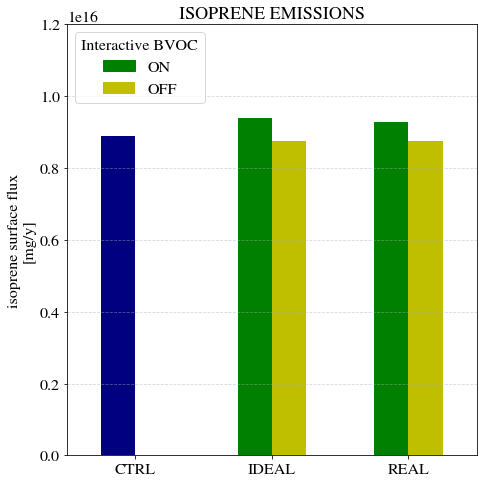

In [263]:
boreal_barplot(bvoc, 'SFisoprene', 'ISOPRENE EMISSIONS', ylim = 1.2*1e16)

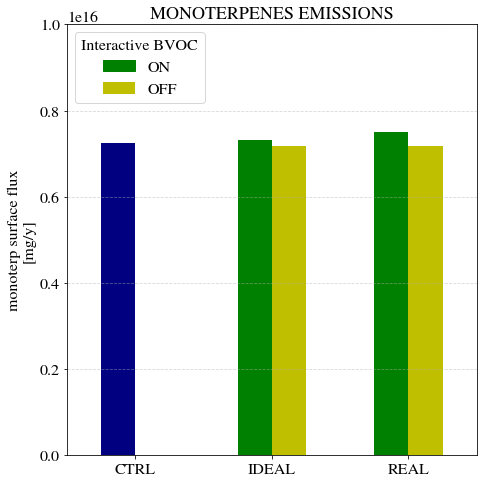

In [255]:
boreal_barplot(bvoc, 'SFmonoterp', 'MONOTERPENES EMISSIONS', ylim = 1e16)

In [257]:
soa = load_dataset_dict('SOA')
for case in casealias:
    soa[case] = fix_soa(fix_names_soa(soa[case]))
    soa[case]['cb_SOA_TOT'] = soa[case]['cb_SOA_NA'] + soa[case]['cb_SOA_A1']
    soa[case]['cb_SOA_TOT'].attrs['long_name'] = "total SOA burden column"

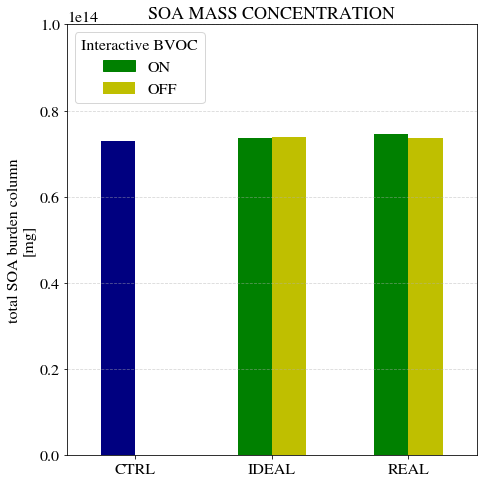

In [262]:
boreal_barplot(soa, 'cb_SOA_TOT', 'SOA MASS CONCENTRATION', ylim=1e14)

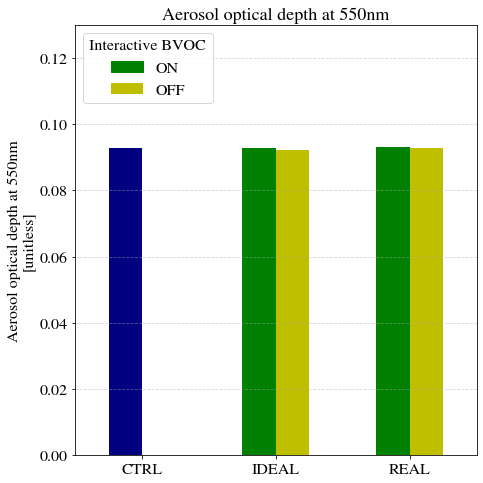

In [267]:
boreal_barplot(soa, 'DOD550', 'Aerosol optical depth at 550nm', ylim=0.13)

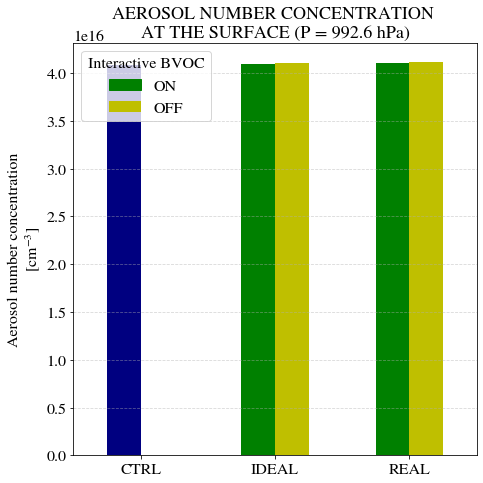

In [275]:
ds=soa
variable = 'N_AER'
title = 'AEROSOL NUMBER CONCENTRATION \nAT THE SURFACE (P = 992.6 hPa)'
boreal_barplot(ds, variable, title, ylim=900)

In [ ]:
cloud = load_dataset_dict('CLOUDPROP')

def fix_cloud(ds):
    
    ds_ = ds.copy(deep=True)
    
    for var in list(ds_.keys()):
            
        if var == "ACTNL":
            ds_[var].values = ds_[var].values*1e-12
        else:
            continue
        return ds_
    
for case in casealias:
    cloud[case] = fix_cloud(cloud[case])

     Run           ON          OFF
0   CTRL  1391.969414     0.000000
1  IDEAL  1470.555882  1372.391244
2   REAL  1455.580080  1372.391244


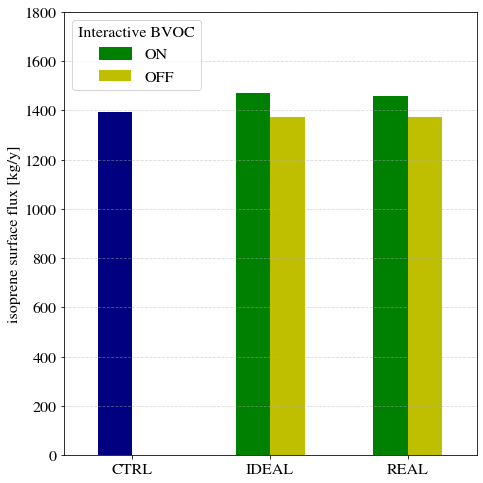

In [173]:
df = pd.DataFrame([['CTRL', global_average(bvoc['CTRL'], 'SFisoprene'), 0.], 
                   ['IDEAL', global_average(bvoc['IDEAL-ON'], 'SFisoprene'), global_average(bvoc['IDEAL-OFF'], 'SFisoprene')], 
                   ['REAL', global_average(bvoc['REAL-ON'], 'SFisoprene'), global_average(bvoc['REAL-OFF'], 'SFisoprene')]],
                  columns=['Run', 'ON', 'OFF'])
# view data
print(df)
  
# plot grouped bar chart
p = df.plot.bar(x='Run', layout='constrained', figsize=[7,7], color=[['navy','g', 'g'],['y','y','y']],
        stacked=False, zorder=0,
        title='')
plt.ylabel('isoprene surface flux [kg/y]')
plt.xlabel('')
#plt.xticks(None)
plt.ylim(0,1800)
plt.xticks(rotation=0)#, ha="right")
plt.legend(loc='upper left',title = 'Interactive BVOC')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('g')
plt.grid(linestyle='--', axis='y', alpha=0.5, zorder=1)
plt.tight_layout()

In [66]:
p

TypeError: 'method' object is not subscriptable

In [52]:
df.plot?


In [12]:
print(mpl.__version__)

3.3.2


In [57]:
df.index.get_level_values(1).unique()

Index(['ON', 'OFF'], dtype='object', name='BVOC')

<AxesSubplot:xlabel='time'>

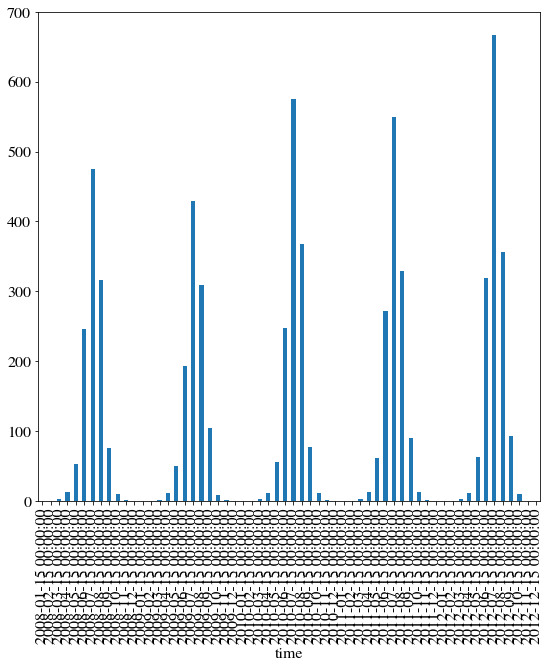

In [7]:
fig, ax = plt.subplots(figsize=(9, 9))
series = bvoc['CTRL']['SFisoprene'].weimean(('lat', 'lon')).to_series()
series.plot.bar(ax=ax)

In [ ]:
print (y.unstack(fill_value=0))
      Chevrolet  Dodge  Ford
1991          1      0     1
1992          2      2     1
1993          3      2     2
1994          0      3     2

y = vl.groupby(['Model Year','Manufacturer']).size()
y.unstack(fill_value=0).plot.bar(width=0.1, align='center')

plt.show()